In [9]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import prediction_error, ResidualsPlot

In [2]:
# Load the DataFrame from the Excel file
file_path = 'STADS_removedActivityCliffs_ECFP42048.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
df.head(1)

(209, 25)


,NEW_SMILES,pIC50,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,FractionCSP3,NumAromaticRings,...,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,Shape Index,Molecular Flexibility,Molecular Complexity,fp
0,CC(=O)N(C)Cc1cc(C(=O)N(C)Cc2cc3ccccc3n2C)ccc1N,5.173925,378.476,2,5,1,4,2,0.272727,3,...,0,71.57,3.011,-3.28,7.760914,3.856356,0.53571,0.608,0.81905,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
print(df.columns)

Index(['NEW_SMILES', 'pIC50', 'amw', 'lipinskiHBD', 'NumRotatableBonds',
       'NumHBD', 'NumHBA', 'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSpiroAtoms', 'NumAtomStereoCenters',
       'tpsa', 'CrippenClogP', 'hallKierAlpha', 'kappa2', 'kappa3',
       'Shape Index', 'Molecular Flexibility', 'Molecular Complexity', 'fp'],
      dtype='object')


In [5]:
# Remove specified columns from the dataframe
df = df.drop(columns = ['NEW_SMILES'])

In [6]:
print(df.columns)

Index(['pIC50', 'amw', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA',
       'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSpiroAtoms', 'NumAtomStereoCenters',
       'tpsa', 'CrippenClogP', 'hallKierAlpha', 'kappa2', 'kappa3',
       'Shape Index', 'Molecular Flexibility', 'Molecular Complexity', 'fp'],
      dtype='object')


In [7]:
# Apply ast.literal_eval only if the element is a string
df['fp'] = df['fp'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x))

# Extract features and target variable
X = np.stack(df['fp'].values)
y = df['pIC50'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10001010)


### **Parameters optimization**

In [ ]:
# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up a hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [-1, None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the metric
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the random search model on the training data
random_search.fit(X_train, y_train)

# Retrieve the best model
best_rf = random_search.best_estimator_

# Make predictions on both training and test sets
train_predictions = best_rf.predict(X_train)
test_predictions = best_rf.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Print results
print("Best Hyperparameters:", random_search.best_params_)
print("Random Forest Regression Performance with Optimized Hyperparameters:")
print(f"Training MSE: {mse_train}")
print(f"Test MSE: {mse_test}")
print(f"Training R^2: {r2_train}")
print(f"Test R^2: {r2_test}")


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.0s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.6s
[CV] END bootstrap=True, max_depth=50, 

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Random Forest Regression Performance with Optimized Hyperparameters:
Training MSE: 0.08687811737334819
Test MSE: 0.24998943096309384
Training R^2: 0.877416119409377
Test R^2: 0.73512119632456


# Random Forest Regression

In [10]:
# Define the Random Forest model with the best hyperparameters
best_rf = RandomForestRegressor(
    n_estimators=400,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=10,
    bootstrap=False,
    random_state=42
)

# Train the model on the training data
best_rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=400, random_state=42)

In [11]:
# Make predictions on both training and test sets
train_predictions = best_rf.predict(X_train)
test_predictions = best_rf.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2_test = r2_score(y_test, test_predictions)
r2_train = r2_score(y_train, train_predictions)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(y_test, test_predictions)
spearman_train, _ =spearmanr(y_train, train_predictions)

# Print performance metrics and Spearman correlation
print(f"The mean absolute error: {mae}")
print(f"The root mean squared error: {rmse}")
print(f"Spearman correlation on test set: {spearman_corr}")
print(f"Spearman correlation on train set: {spearman_train}")


The mean absolute error: 0.41802850590800905
The root mean squared error: 0.4999894308513869
Spearman correlation on test set: 0.8581335849898277
Spearman correlation on train set: 0.9401297314292488


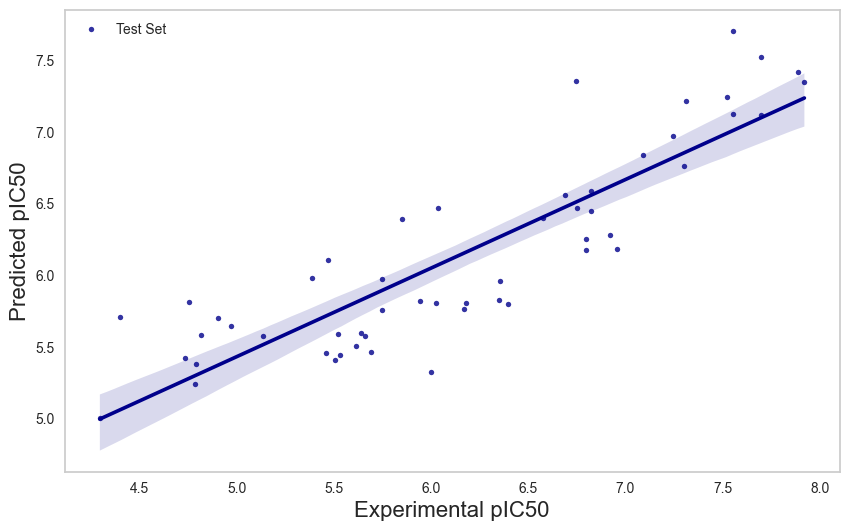

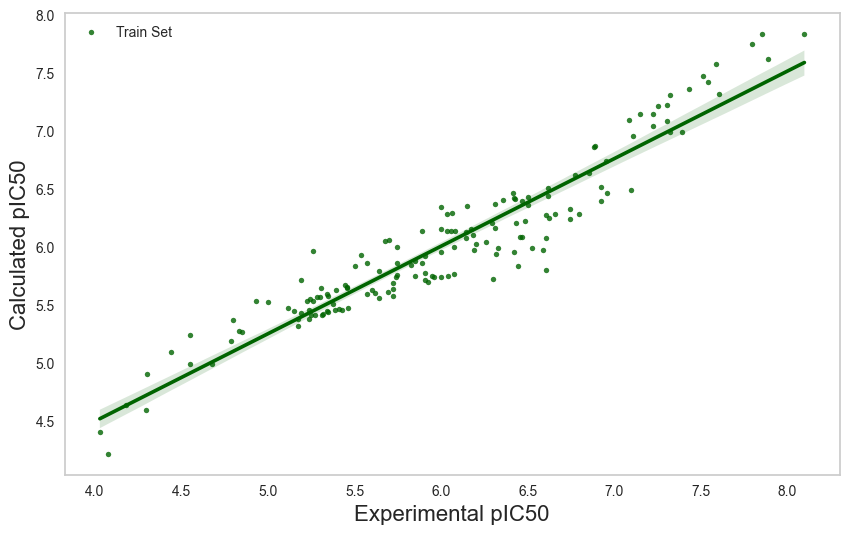

In [13]:
# Plot predictions vs actual for the test set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_test, y=test_predictions, scatter_kws={'s':15}, color='darkblue', label='Test Set')

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Predicted pIC50", fontsize=16)  # Set y-axis label with font size
ax.grid(False)
# Display the plot for the test set
plt.legend()
plt.show()

# Plot predictions vs actual for the training set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_train, y=train_predictions, scatter_kws={'s':15}, color='darkgreen', label='Train Set')

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Calculated pIC50", fontsize=16) 
ax.grid(False)
# Display the plot for the training set
plt.legend()
plt.show()


In [14]:
# Define a custom scoring function for Spearman correlation
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]  # Only return the correlation coefficient

# Create a scorer based on the custom Spearman function
spearman_scorer = make_scorer(spearman_corr, greater_is_better=True)

# Perform cross-validation with 5 folds using the Spearman correlation as the scoring metric
cv_scores_spearman = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=spearman_scorer)

# Print the cross-validation Spearman correlation scores
print(f"Cross-Validation Spearman Correlation Scores: {cv_scores_spearman}")
print(f"Mean Cross-Validation Spearman Correlation Score: {cv_scores_spearman.mean()}")


Cross-Validation Spearman Correlation Scores: [0.51237398 0.63111201 0.81861262 0.79798387 0.79141043]
Mean Cross-Validation Spearman Correlation Score: 0.7102985821703534


In [23]:
# Set up Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Use MSE as the scoring function for LOOCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform LOOCV using MSE as the scoring metric
loocv_scores = cross_val_score(best_rf, X, y, cv=loo, scoring=mse_scorer)

# Calculate the mean MSE score from LOOCV (note that cross_val_score returns negative MSE values)
mean_loocv_mse = -loocv_scores.mean()

# Output the LOOCV MSE scores and the mean MSE score
#print(f"LOOCV MSE scores: {loocv_scores}")
print(f"Mean LOOCV MSE score: {mean_loocv_mse}")

Mean LOOCV MSE score: 0.308858966084674


### **Making prediction of new data on trained model**

In [44]:
# Prepare the New Dataset
new_file_path = 'file with compounds generated by transformation rules.txt'  # Replace with your actual file path
new_df = pd.read_csv(new_file_path)

In [45]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
new_df.head(1)

(209, 24)


,NEW_SMILES,Shape Index,Molecular Flexibility,Molecular Complexity,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,...,NumHeterocycles,NumAromaticHeterocycles,NumSpiroAtoms,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,fp
0,Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1,0.55172,0.33101,0.88694,381.475,2,3,2,3,0,...,1,1,0,0,45.39,5.6731,-3.46,7.173162,3.401712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [46]:
if 'fp' in new_df.columns:
    new_df['fp'] = new_df['fp'].apply(ast.literal_eval)
    new_df['fp'] = new_df['fp'].apply(lambda x: np.array(x))

In [47]:
#Use the Trained Model to Make Predictions on the New Dataset
X_new = np.stack(new_df['fp'].values)
predictions_new = best_rf.predict(X_new)

In [48]:
#Assign Predicted pIC50 Values to Respective SMILES
new_df = new_df.copy()
new_df['Predicted_pIC50'] = predictions_new
print(new_df[['NEW_SMILES', 'Predicted_pIC50']].head())
print(len(new_df))
print(len(new_df.shape))

                                          NEW_SMILES  Predicted_pIC50
0   Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1         5.834342
1  N=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3ccccc...         5.920662
2  O=C(Oc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.080513
3  O=C(Nc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.039099
4  O=C(Sc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.009527
172026
2


In [49]:
new_df.to_csv('Save your file.txt', index=False)

In [50]:
# Analyze predicted pIC50 values
print(new_df['Predicted_pIC50'].describe())


count    172026.000000
mean          6.058643
std           0.277867
min           5.391686
25%           5.919094
50%           6.006143
75%           6.101573
max           7.475071
Name: Predicted_pIC50, dtype: float64
